## 5.3 레버리지와 아웃라이어

### 레버리지

개별적인 데이터 표본 하나하나가 회귀분석 결과에 미치는 영향력은 레버리지 분석이나 아웃라이어 분석을 통해 알 수 있다.

**레버리지(leverage)**는 실제 종속변수값 $y$가 예측치(predicted target) $\hat{y}$에 미치는 영향을 나타낸 값이다. self-influence, self-sensitivity 라고도 한다.

가중치 벡터의 결과값을 예측식에 대입하여 $y$ 와 $\hat{y}$의 관계를 다음과 같다는 것을 보였었다.

$$  \hat{y} =  Hy $$

이 행렬 $H$를 **영향도 행렬**(influence matrix) 또는 **hat 행렬**(hat matrix)이라고 한다고 하였다.

행렬 $H$의 $i$번째 행, $j$번째 열 성분을 $h_{ij}$라고 하면 실제 결과값 $y_i$과 예측값 $\hat{y}_i$은 다음과 같은 관계를 가진다.

$$
\hat{y}_i = h_{i1} y_1 + h_{i2} y_2 + \cdots + h_{ii} y_i + \cdots + h_{iN} y_N 
$$

레버리지는 수학적으로 **영향도 행렬의 대각성분 $h_{ii}$**으로 정의된다. 즉, 레버리지는 실제의 결과값 $y_i$이 예측값 $\hat{y}_i$에 미치는 영향, 즉 예측점을 자기 자신의 위치로 끌어 당기는 정도를 나타낸 것이다. 

만약  $h_{ii}$ 값이 1이 되고 나머지 성분들이 모두 0이 될 수만 있다면 모든 표본 데이터에 대해 실제 결과값과 예측값이 일치하게 될 것이다.

$$ h_{ii} = 1, h_{ij} = 0 \; (\text{for } i \neq j) \;\; \rightarrow \;\; \hat{y}_i = y_i $$

하지만 곧 알 수 있듯이 이러한 일은 발생하지 않는다.
레버리지값은 다음과 같은 특성을 가진다는 것을 수학적으로 증명할 수 있다.

1. 1보다 같거나 작은 양수 혹은 0이다.

    $$  0 \leq h_{ii} \leq 1 $$
    
2. 레버리지의 합은 모형에 사용된 모수의 갯수 $K$와 같다. 모수에는 상수항도 포함되므로 상수항이 있는 1차원 모형에서는 $K = 2$가 된다.

    $$  \text{tr}(H) = \sum_i^N h_{ii} = K $$

이 두가지 성질로부터 레버리지 값은 $N$개의 데이터에 대한 레버리지값은 양수이고 그 합이 $K$가 된다는 것을 알 수 있다. 즉 $K$라고 하는 값을 $N$개의 변수가 나누어 가지는 것과 같다. 현실적으로 데이터의 갯수 $N$는 모수의 갯수 $K$보다 훨씬 많기 때문에 위에서 말한 특성을 적용하면 모든 레버리지 값이 동시에 1이 되는 것은  불가능하다.

위 식을 이용하면 레버리지의 평균값도 구할 수 있다. 

$$ h_{ii} \approx \dfrac{K}{N} $$

보통 이 평균값의 2 ~ 4배보다 레버리지 값이 크면 레버리지가 크다고 이야기한다.

### statsmodels를 이용한 레버리지 계산

레버리지 값은 `RegressionResults` 클래스의 `get_influence` 메서드로 다음과 같이 구할 수 있다. 우선 다음과 같은 가상의 1차 데이터로 회귀분석 예제를 풀어보자.

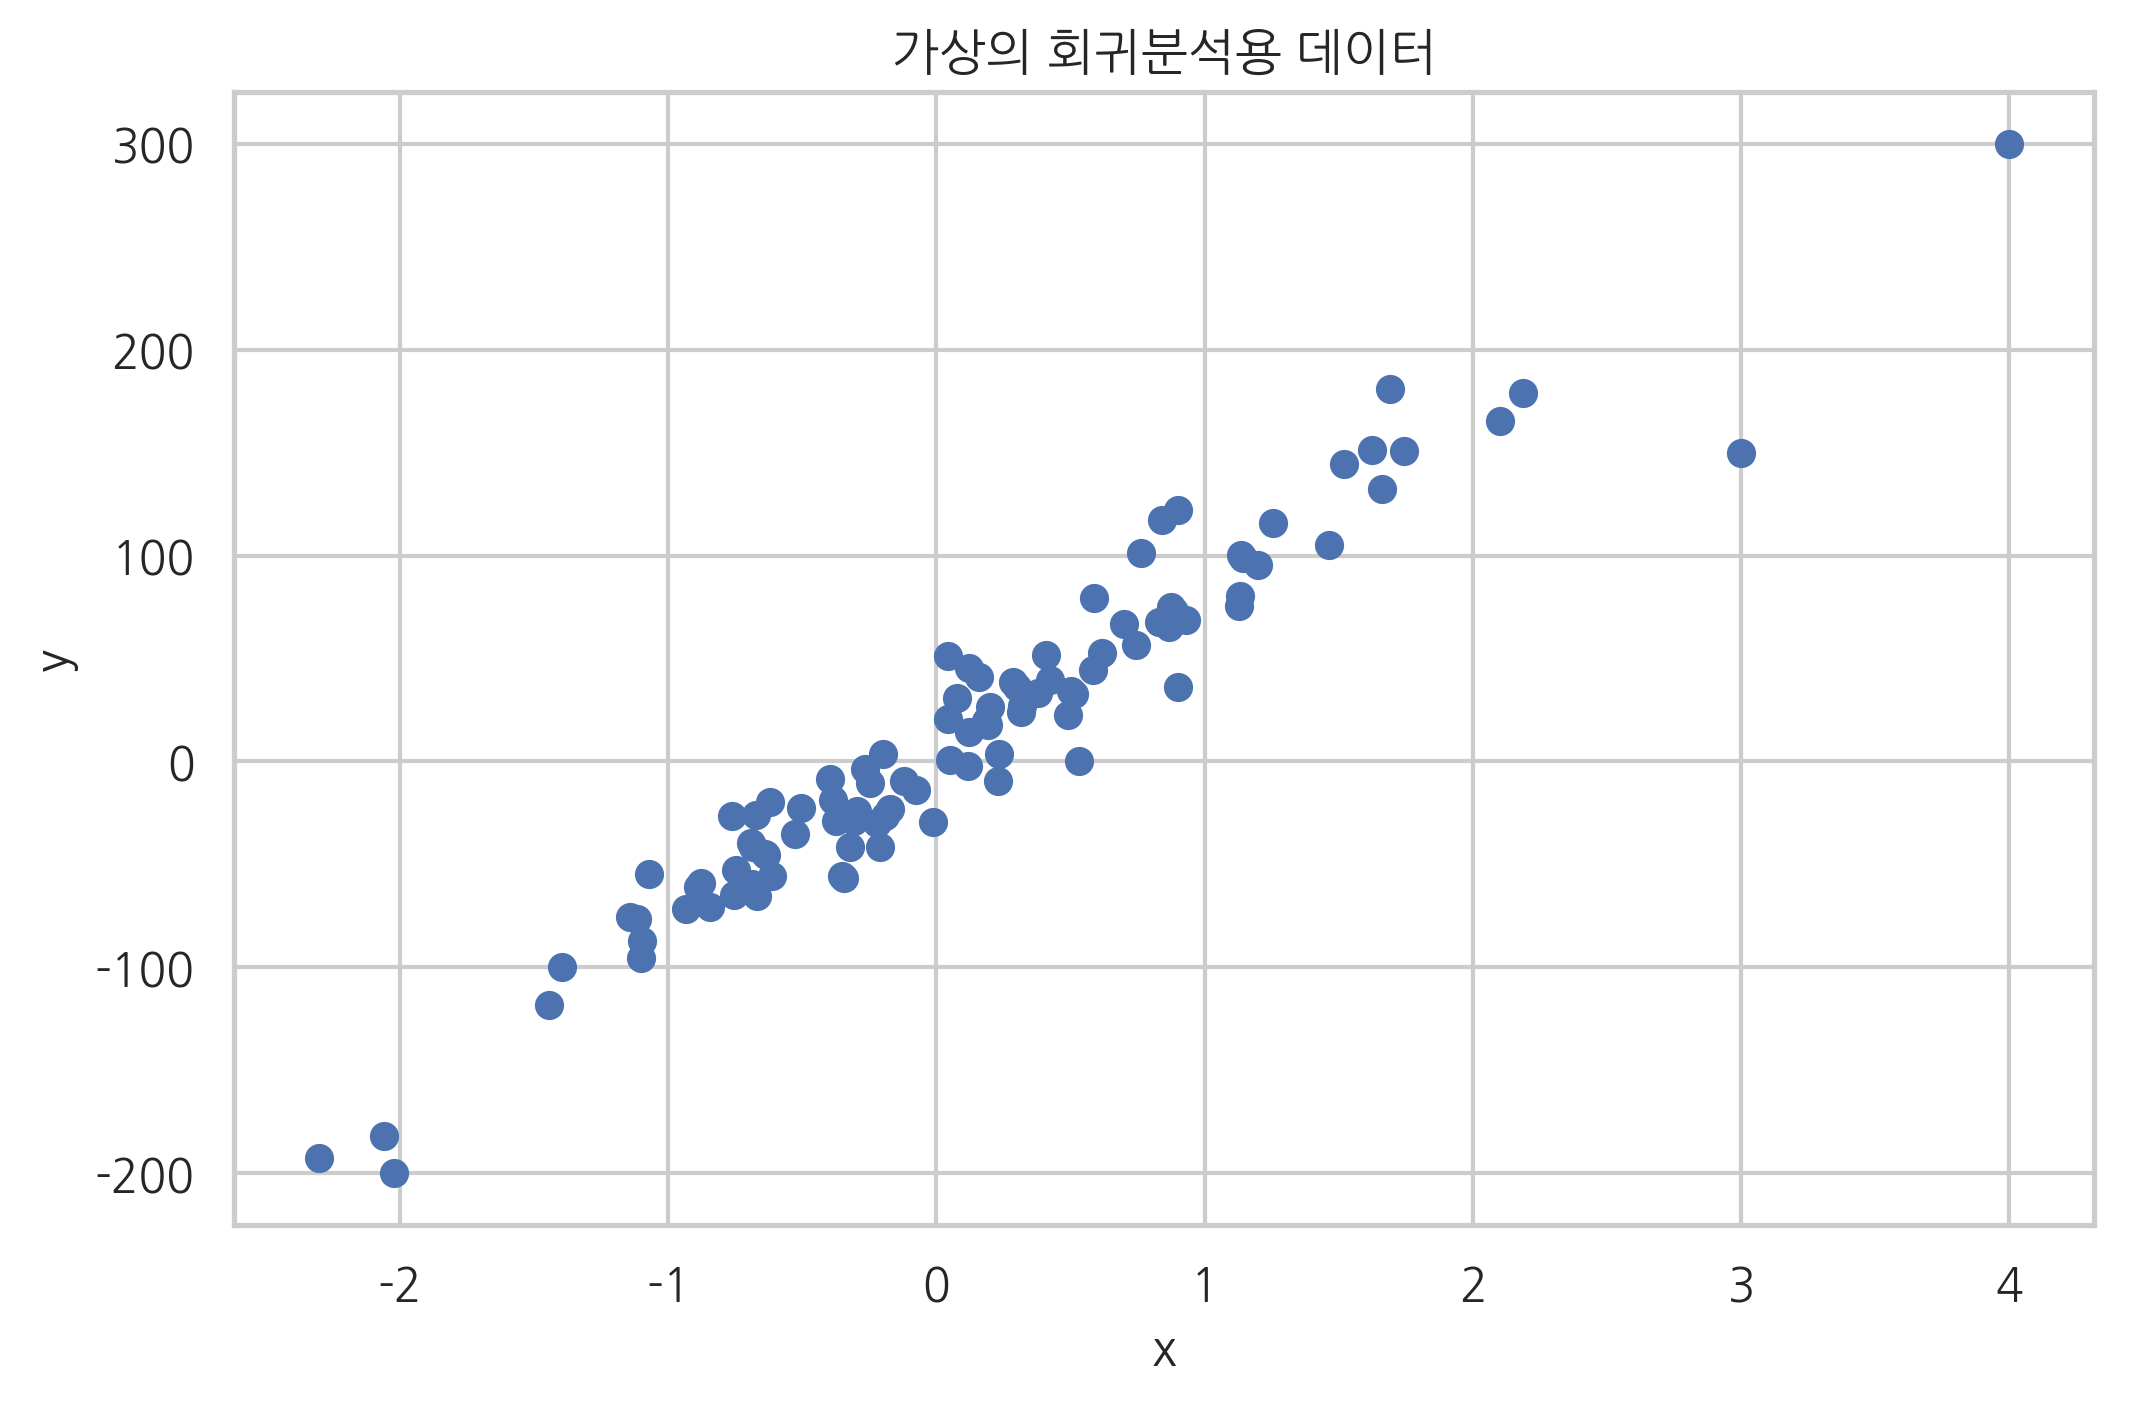

In [1]:
from sklearn.datasets import make_regression

# 100개의 데이터 생성
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=1)

# 레버리지가 높은 가상의 데이터를 추가
data_100 = (4, 300)
data_101 = (3, 150)
X0 = np.vstack([X0, np.array([data_100[:1], data_101[:1]])])
X = sm.add_constant(X0)
y = np.hstack([y, [data_100[1], data_101[1]]])

plt.scatter(X0, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("가상의 회귀분석용 데이터")
plt.show()

이 데이터를 이용하여 선형회귀를 한 결과는 다음과 같다.

In [2]:
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           1.61e-61
Time:                        09:35:48   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              3.2565      2.065      1.577      0.1

선형회귀 결과에서 `get_influence` 메서드를 호출하면 영향도 정보 객체를 구할 수 있다. 이 객체는 `hat_matrix_diag` 속성으로 레버리지 벡터의 값을 가지고 있다.  

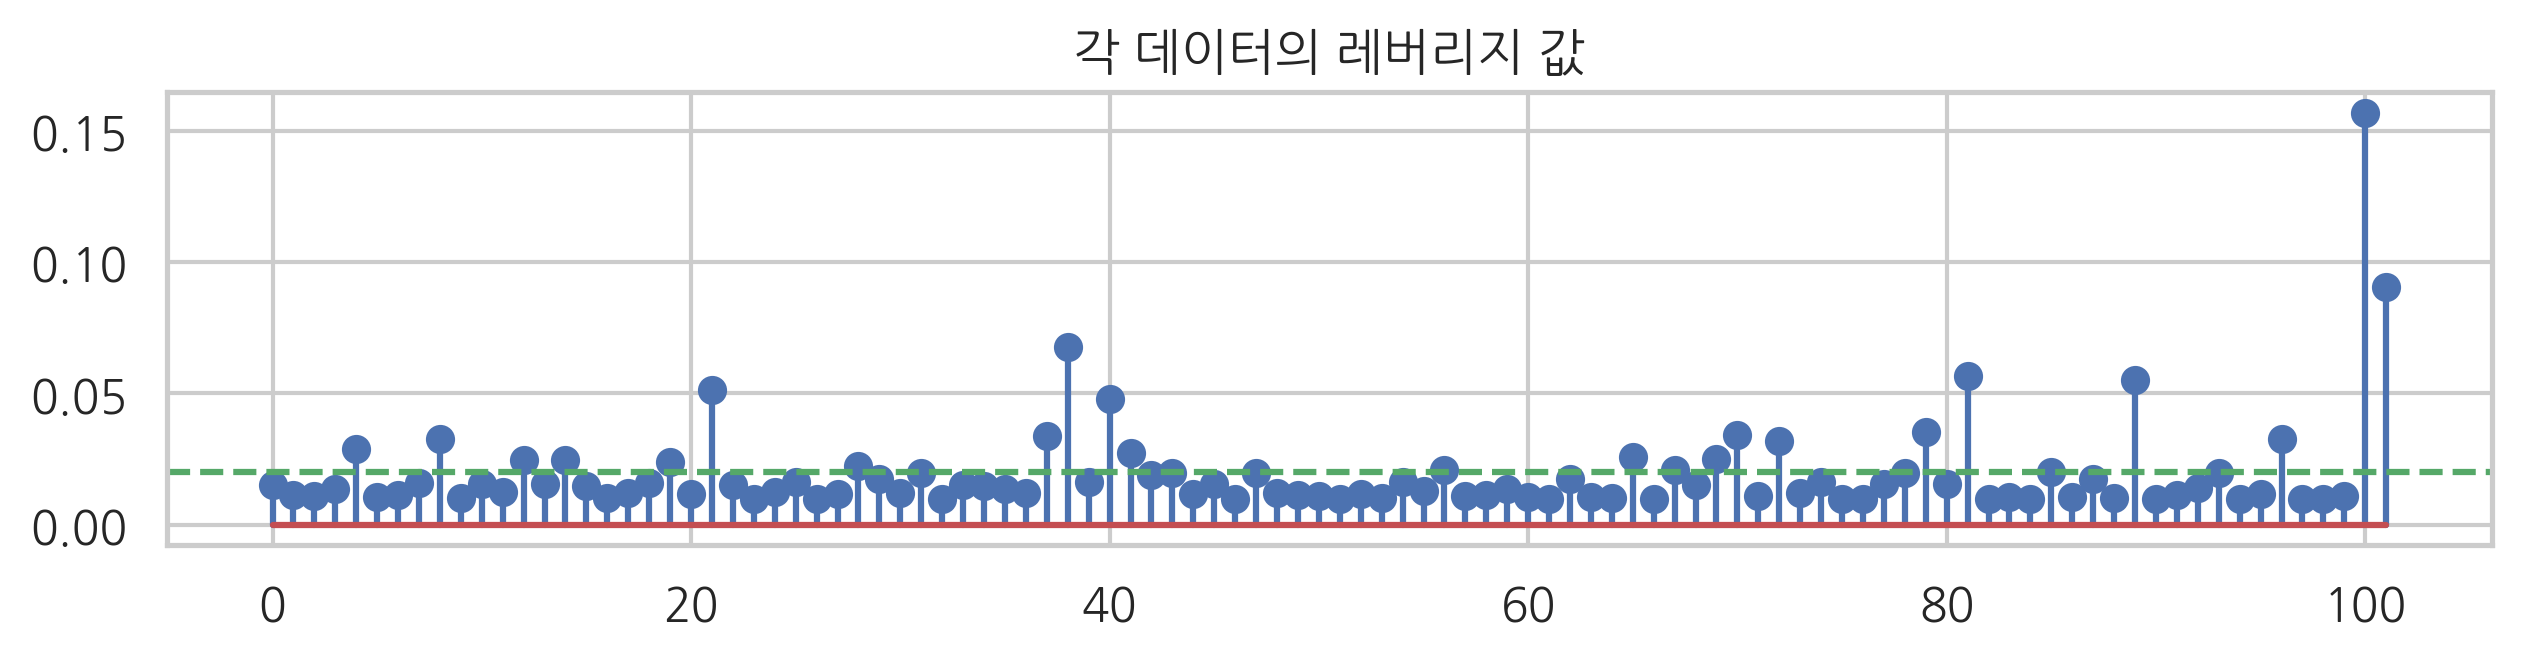

In [3]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.axhline(0.02, c="g", ls="--")
plt.title("각 데이터의 레버리지 값")
plt.show()

수동으로 추가한 마지막 두 개의 데이터를 제외하면 대부분의 데이터는 레버리지 값이 0.02 근처의 낮은 값을 가진다. 

$$ \text{레버리지 평균} \approx \dfrac{2}{102} \approx 0.02 $$

레버리지의 합이 2와 같아진다는 것도 다음과 같이 확인할 수 있다.

In [4]:
hat.sum()

2.0000000000000004

위 결과를 이용하여 레버리지가 큰 데이터만 표시하면 아래와 같다. 여기에서는 레버리지 값이 0.05를 넘는 데이터만 큰 원으로 표시하였다.

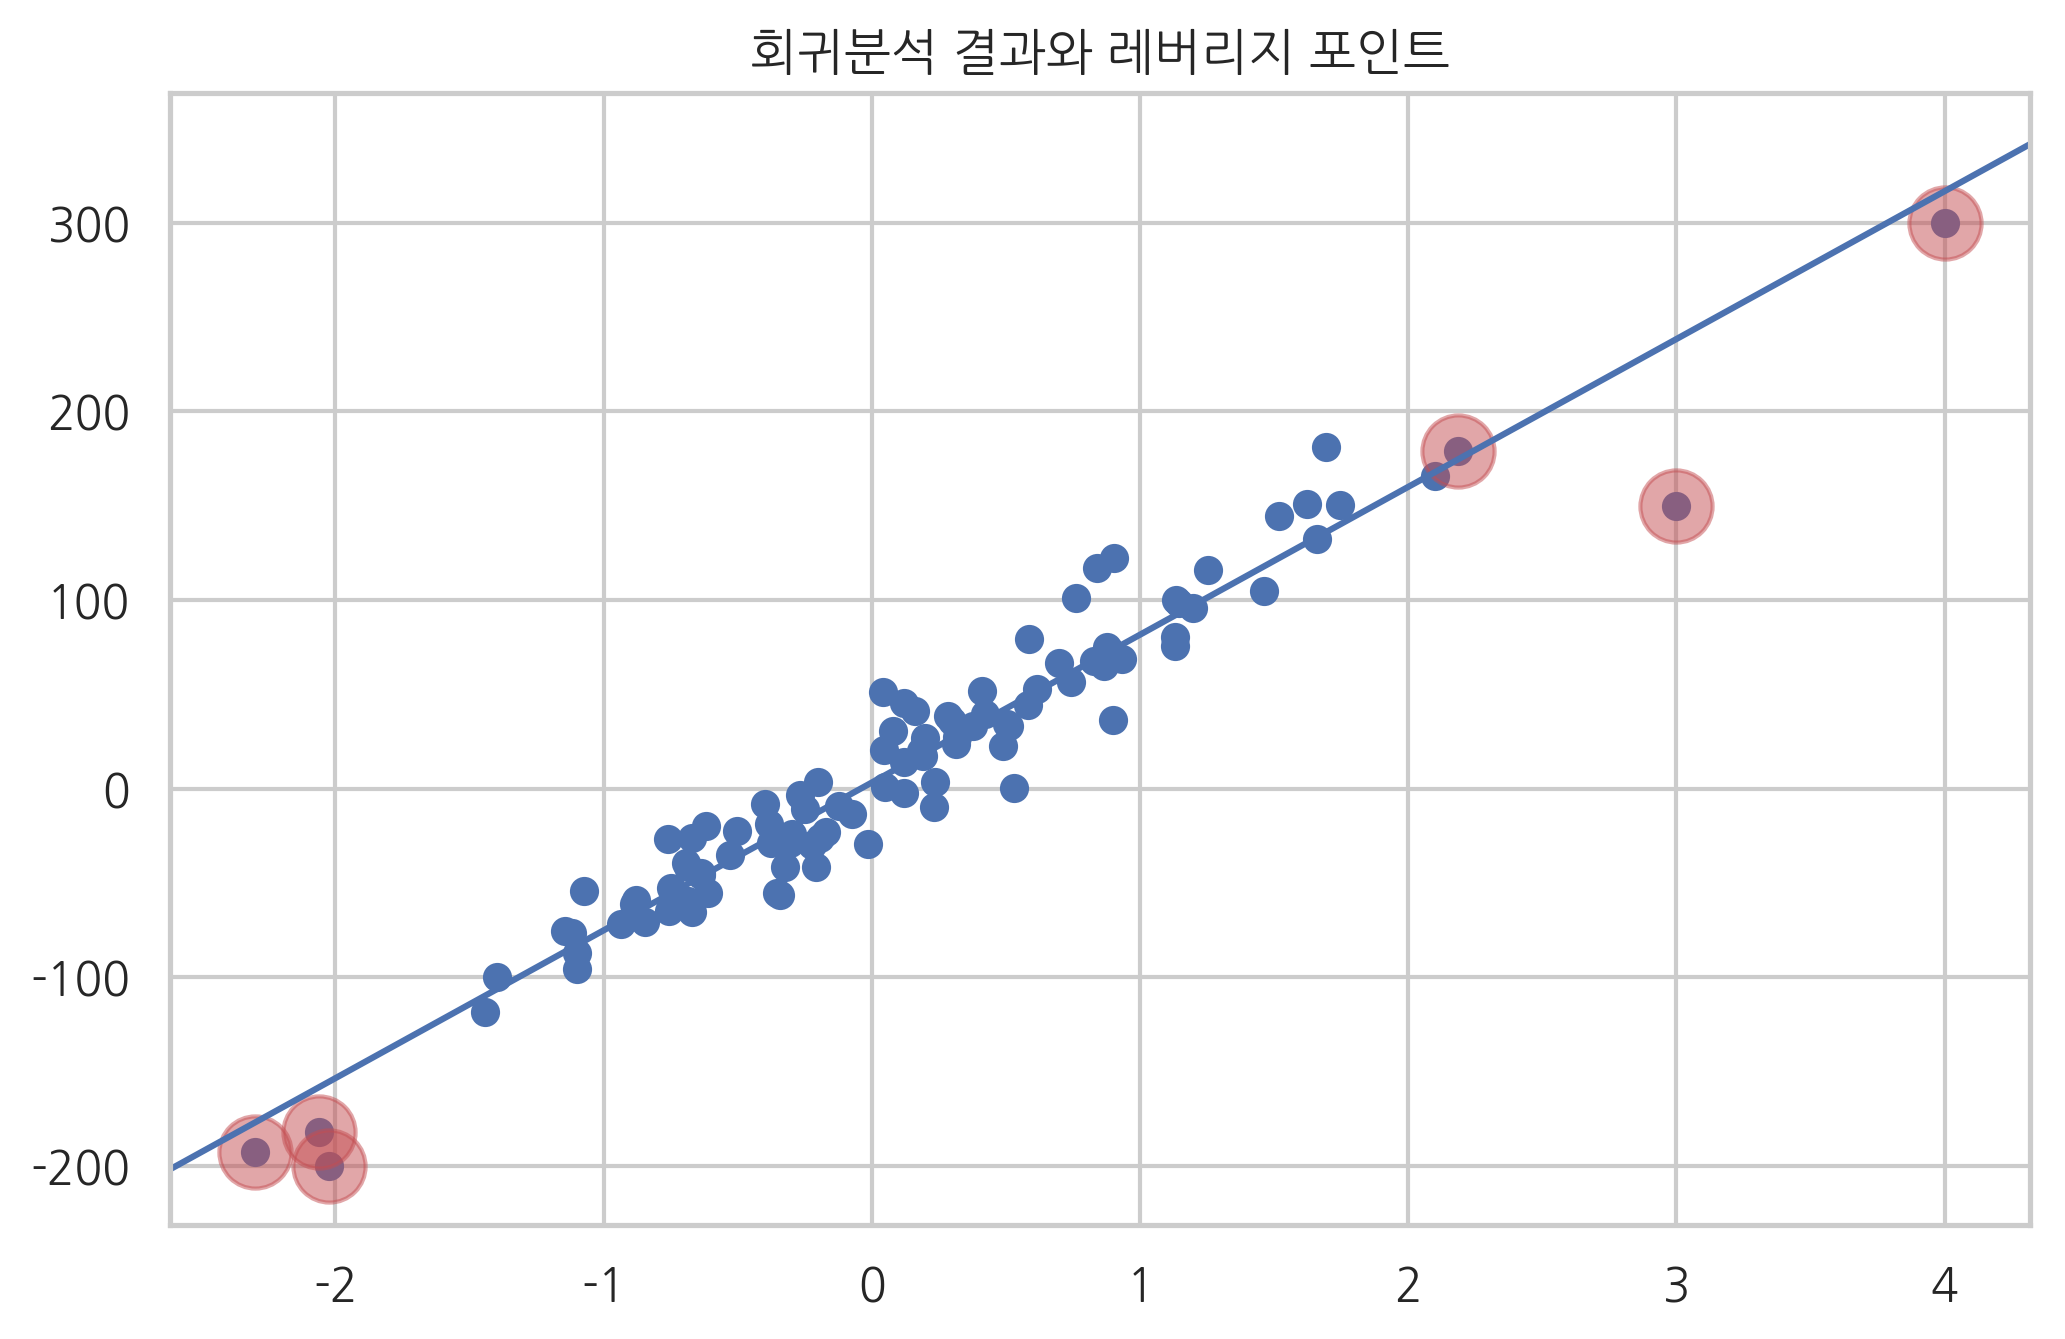

In [5]:
ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=ax)

idx = hat > 0.05
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.title("회귀분석 결과와 레버리지 포인트")
plt.show()

위 그림에서 데이터가 무리지어 있지 않고 단독으로 존재할수록 레버리지가 커짐을 알 수 있다.

### 레버리지의 영향

레버리지가 큰 데이터가 모형에 주는 영향을 보기 위해 이 데이터가 포함된 경우의 모형과 포함되지 않은 경우의 모형을 아래에 비교하였다. 레버리지가 큰 데이터는 포함되거나 포함되지 않는가에 따라 모형에 주는 영향이 큰 것을 알 수 있다.

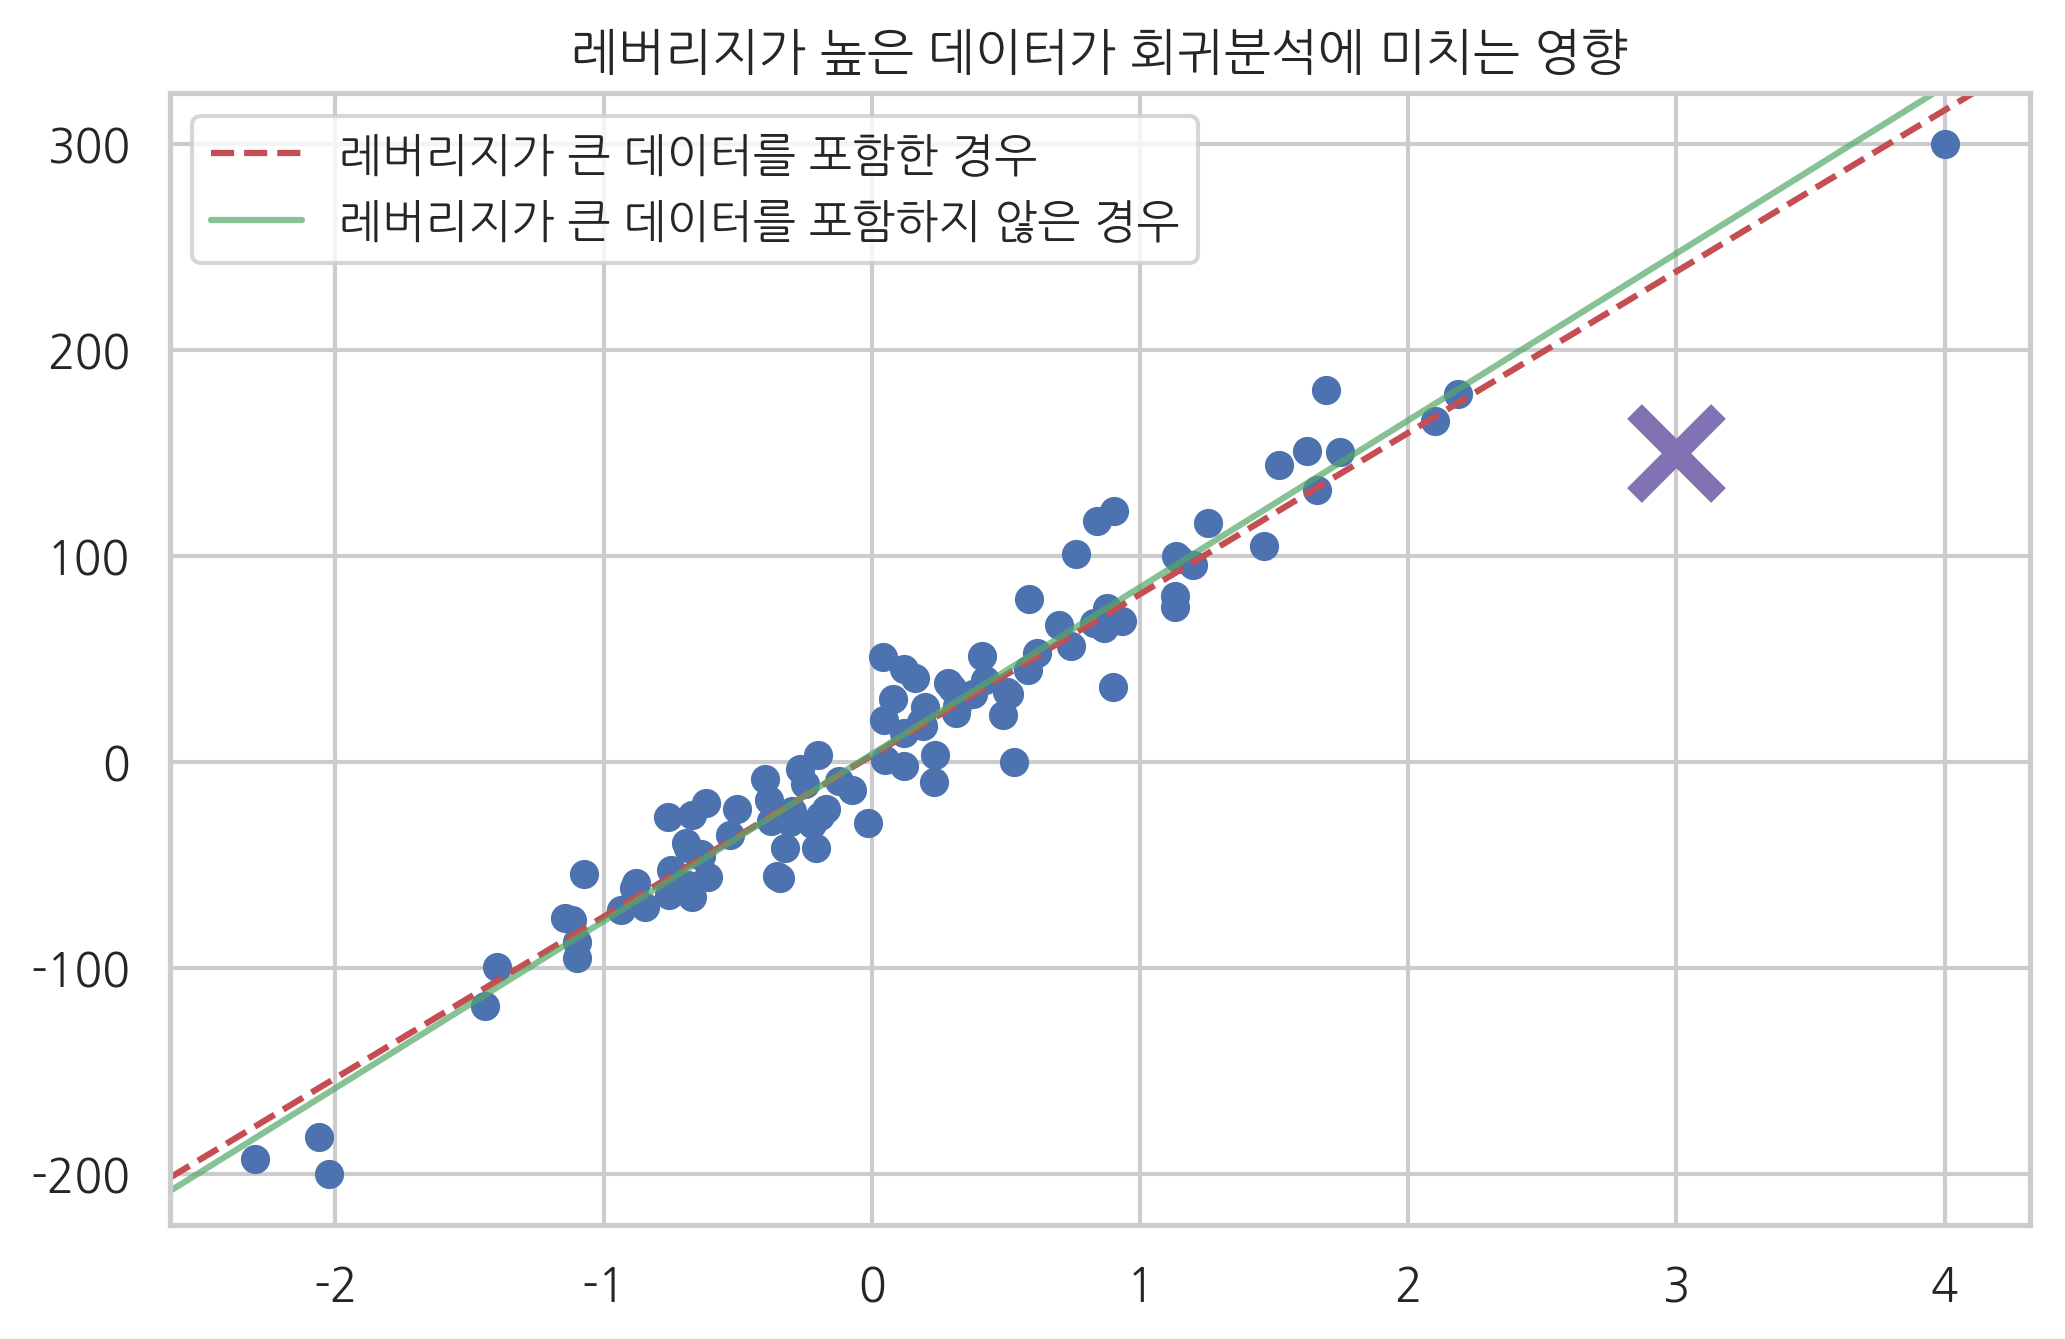

In [6]:
model2 = sm.OLS(y[:-1], X[:-1])
result2 = model2.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result2,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-1], y[-1], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 큰 데이터를 포함한 경우", u"레버리지가 큰 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지가 높은 데이터가 회귀분석에 미치는 영향")
plt.show()

반대로 레버리지가 작은 데이터는 포함되거나 포함되지 않거나 모형이 별로 달라지지 않는 것을 알 수 있다.

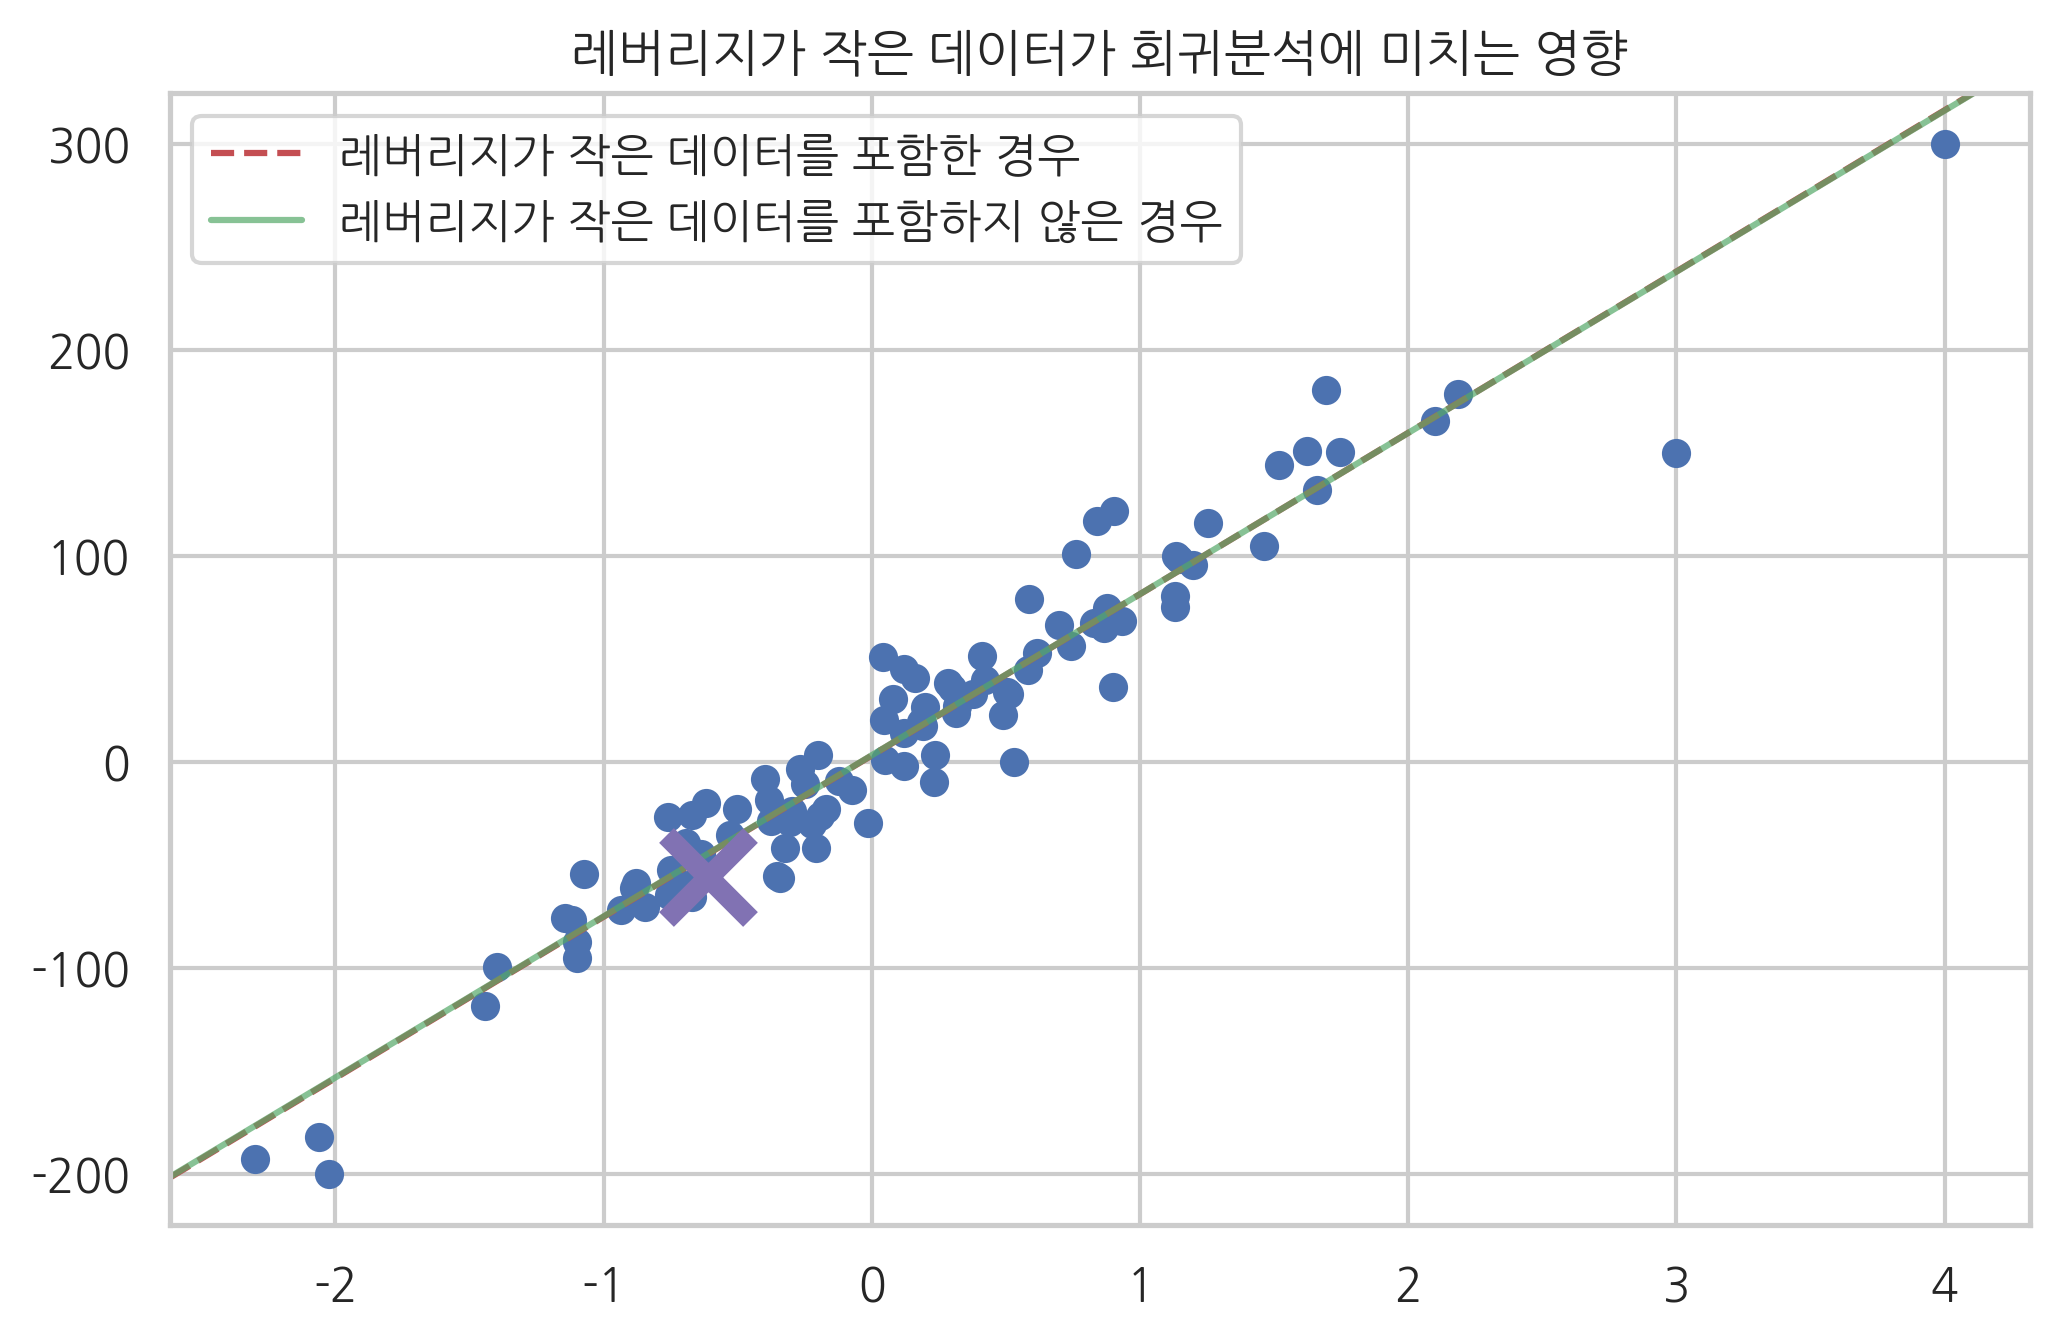

In [7]:
model3 = sm.OLS(y[1:], X[1:])
result3 = model3.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result3,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[0], y[0], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 작은 데이터를 포함한 경우", u"레버리지가 작은 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지가 작은 데이터가 회귀분석에 미치는 영향")
plt.show()

혹은 레버리지가 크더라도 오차가 작은 데이터는 포함되거나 포함되지 않거나 모형이 별로 달라지지 않는다.

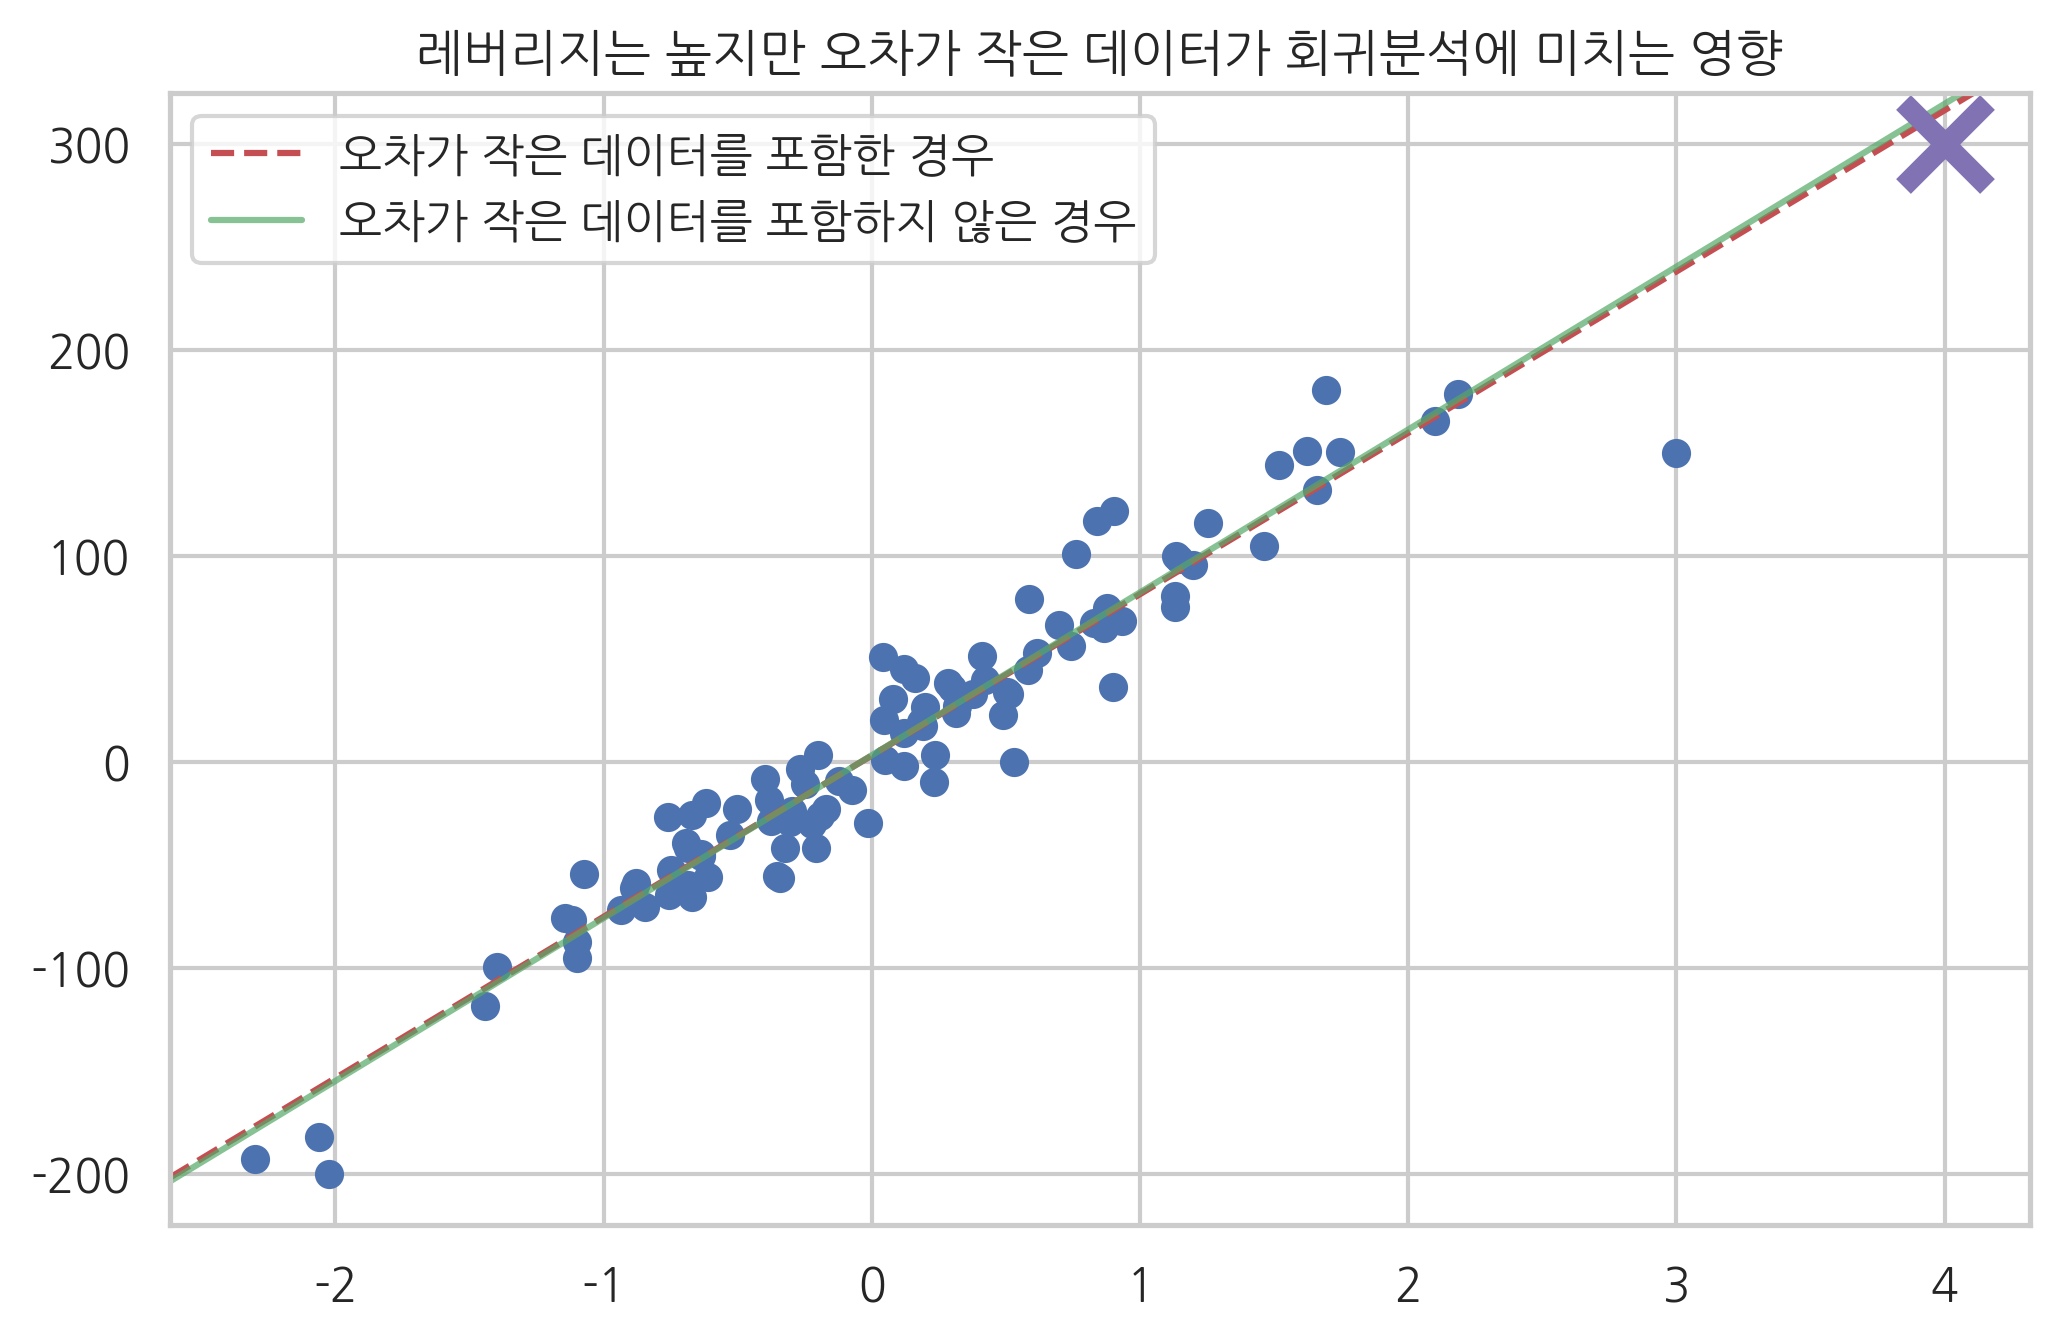

In [8]:
idx = np.array(list(range(100)) + [101])
model4 = sm.OLS(y[idx], X[idx, :])
result4 = model4.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result4,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-2], y[-2], marker='x', c="m", ms=20, mew=5)
plt.legend([u"오차가 작은 데이터를 포함한 경우", u"오차가 작은 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지는 높지만 오차가 작은 데이터가 회귀분석에 미치는 영향")
plt.show()

### 아웃라이어

모형에서 설명하고 있는 데이터와 동떨어진 값을 가지는 데이터, 즉 잔차가 큰 데이터를 **아웃라이어(outlier)**라고 한다.
그런데 잔차의 크기는 독립 변수의 영향을 받으므로 아웃라이어를 찾으러면 이 영향을 제거한 표준화된 잔차를 계산해야 한다.

### 표준화 잔차

개별적인 잔차의 표준편차를 구하면 다음과 같다.

$$ e = (I - H) \epsilon = M \epsilon $$

$$
\begin{eqnarray}
\text{Cov}[e] 
&=& \text{E}[M \epsilon\epsilon^T M^T] \\
&=& M \text{E}[\epsilon\epsilon^T] M^T \\
&=& M \sigma^2 I M^T \\
&=& \sigma^2MM^T \\
&=& \sigma^2MM \\
&=& \sigma^2M \\
&=& \sigma^2(I - H) \\
\end{eqnarray}
$$

위 식에서는 $M$이 대칭 행렬이고 $M^2=M$라는 사실을 이용하었다.

대각 성분만 보면 개별적인 잔차의 표준편차는 다음과 같다.

$$ \text{Var}[e_i] = \sigma^2 (1 - h_{ii}) $$ 

즉, 오차의 표준 편차는 모든 표본에 대해 같지만 개별적인 잔차의 표준편차는 레버리지에 따라 달라지는 것을 알 수 있다. 

오차의 분산은 알지 못하므로 잔차 분산으로부터 추정한다.

$$ \text{Var}[e_i] \approx s^2 (1 - h_{ii}) $$ 

이 식에서 $s$는 다음과 같이 구한 오차의 표준편차 추정값이다.

$$ s^2 = \dfrac{e^Te}{N-K} = \dfrac{RSS}{N-K} $$

잔차를 레버리지와 잔차의 표준 편차로 나누어 동일한 표준 편차를 가지도록 스케일링한 것을 **표준화 잔차**(standardized residual 또는 normalized residual 또는 studentized residual)라고 한다.

$$ r_i = \dfrac{e_i}{s\sqrt{1-h_{ii}}} $$


### statsmodels를 이용한 표준화 잔차 계산

아래에서는 각 데이터의 잔차를 표시하였다. 잔차는 `RegressionResult` 객체의 `resid` 속성에 있다.

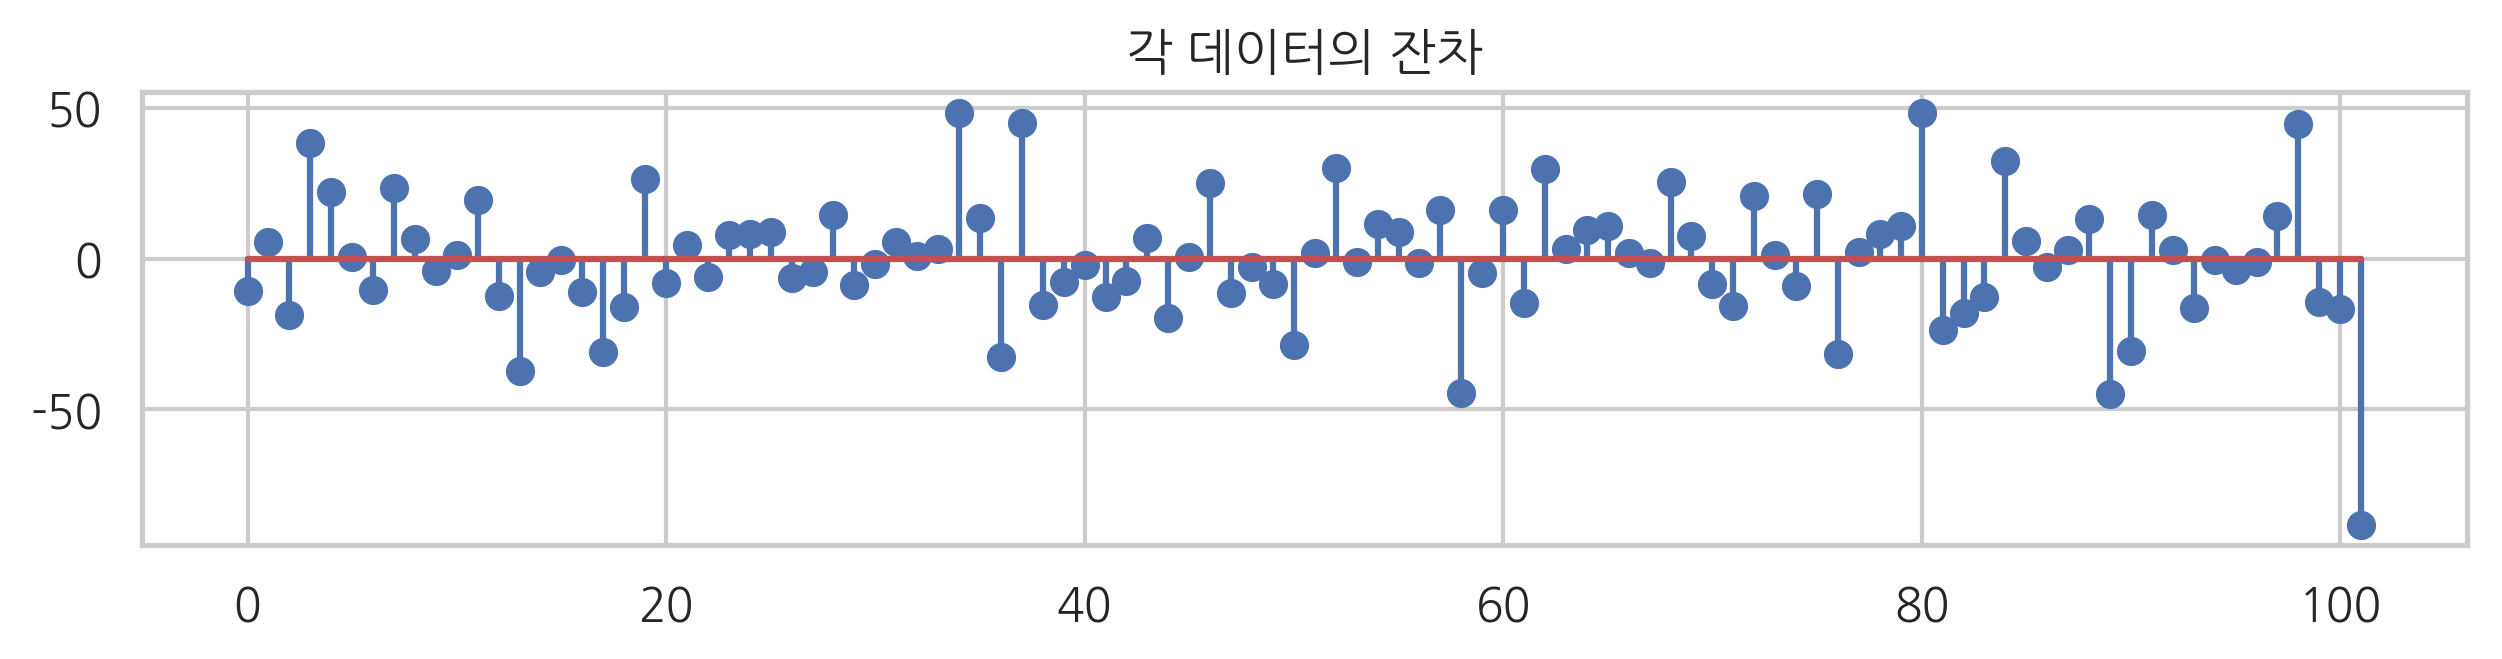

In [9]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid)
plt.title("각 데이터의 잔차")
plt.show()

표준화 잔차는 `resid_pearson` 속성에 있다. 보통 표준화 잔차가 2~4보다 크면 아웃라이어로 본다.

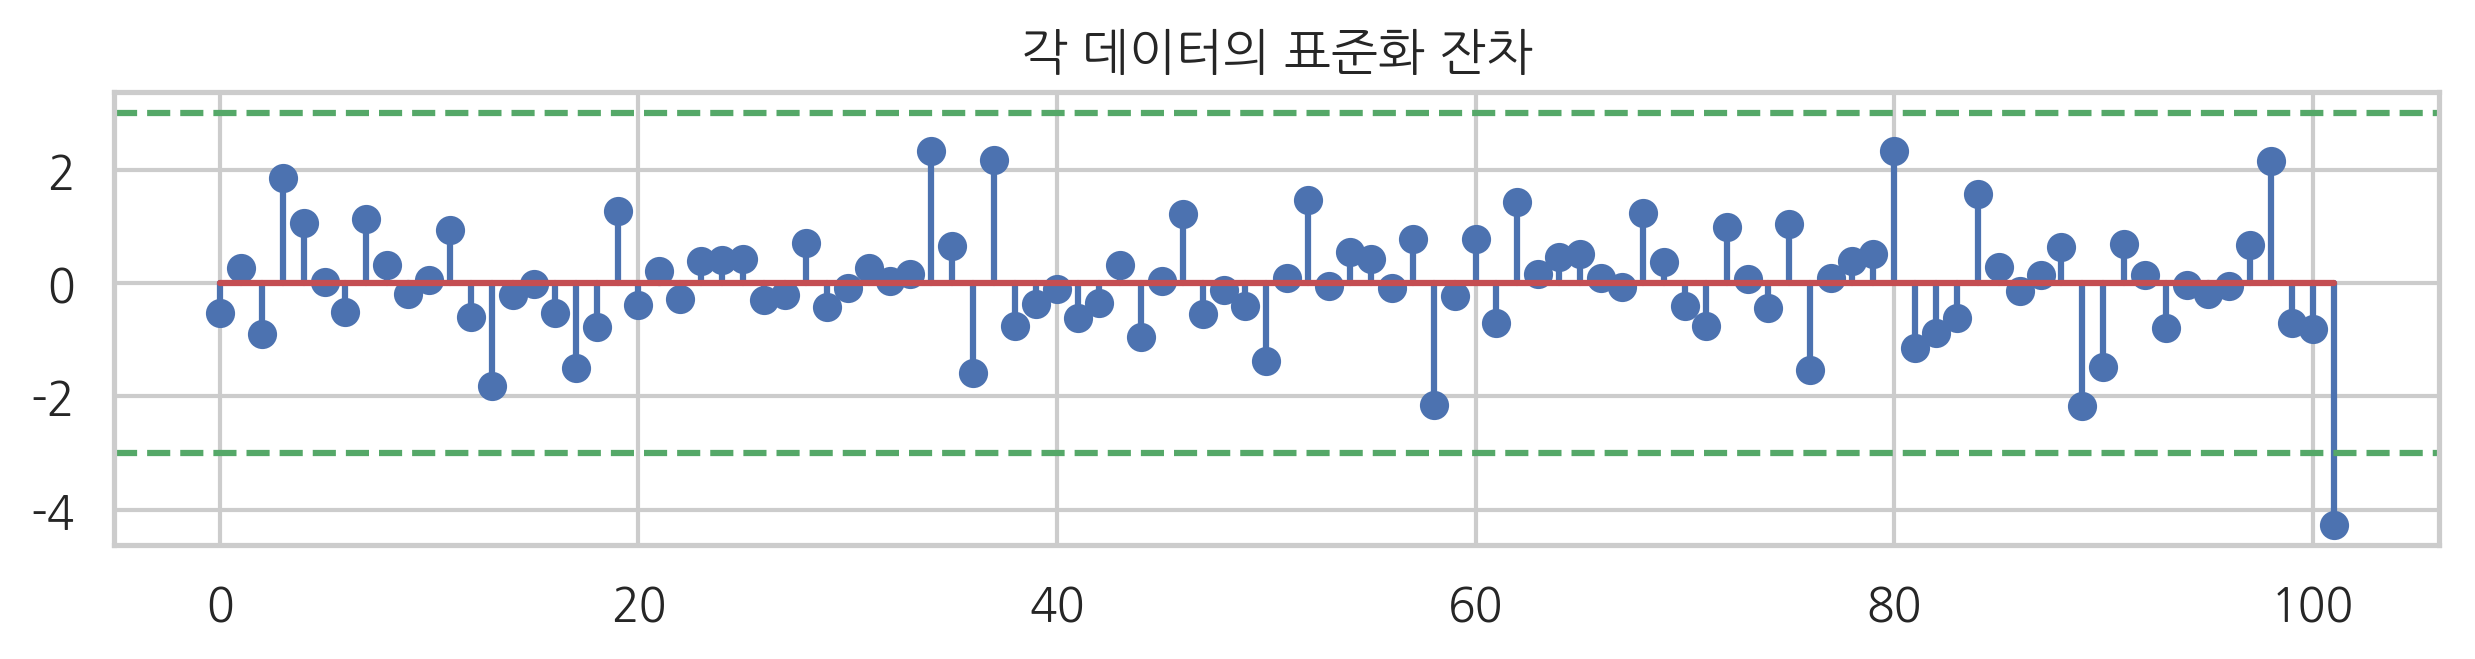

In [10]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.axhline(3, c="g", ls="--")
plt.axhline(-3, c="g", ls="--")
plt.title("각 데이터의 표준화 잔차")
plt.show()

### Cook's Distance

회귀 분석에는 잔차의 크기가 큰 데이터가 아웃라이어가 되는데 이 중에서도 주로 관심을 가지는 것은 레버리지와 잔차의 크기가 모두 큰 데이터들이다. 잔차와 레버리지를 동시에 보기위한 기준으로는 Cook's Distance가 있다.  다음과 같이 정의되는 값으로 레버리지가 커지거나 잔차의 크기가 커지면 Cook's Distance 값이 커진다.

$$ D_i = \frac{r_i^2}{\text{RSS}}\left[\frac{h_{ii}}{(1-h_{ii})^2}\right] $$

Fox' Outlier Recommendation 은 Cook's Distance가 다음과 같은 기준값보다 클 때 아웃라이어로 판단하자는 것이다.

$$ D_i > \dfrac{4}{N − K - 1} $$

모든 데이터의 레버리지와 잔차를 동시에 보려면 `plot_leverage_resid2` 명령을 사용한다. 이 명령은 x축으로 표준화 잔차의 제곱을 표시하고 y축으로 레버리지값을 표시한다. 데이터 아이디가 표시된 데이터들이 레버리지가 큰 아웃라이어이다.

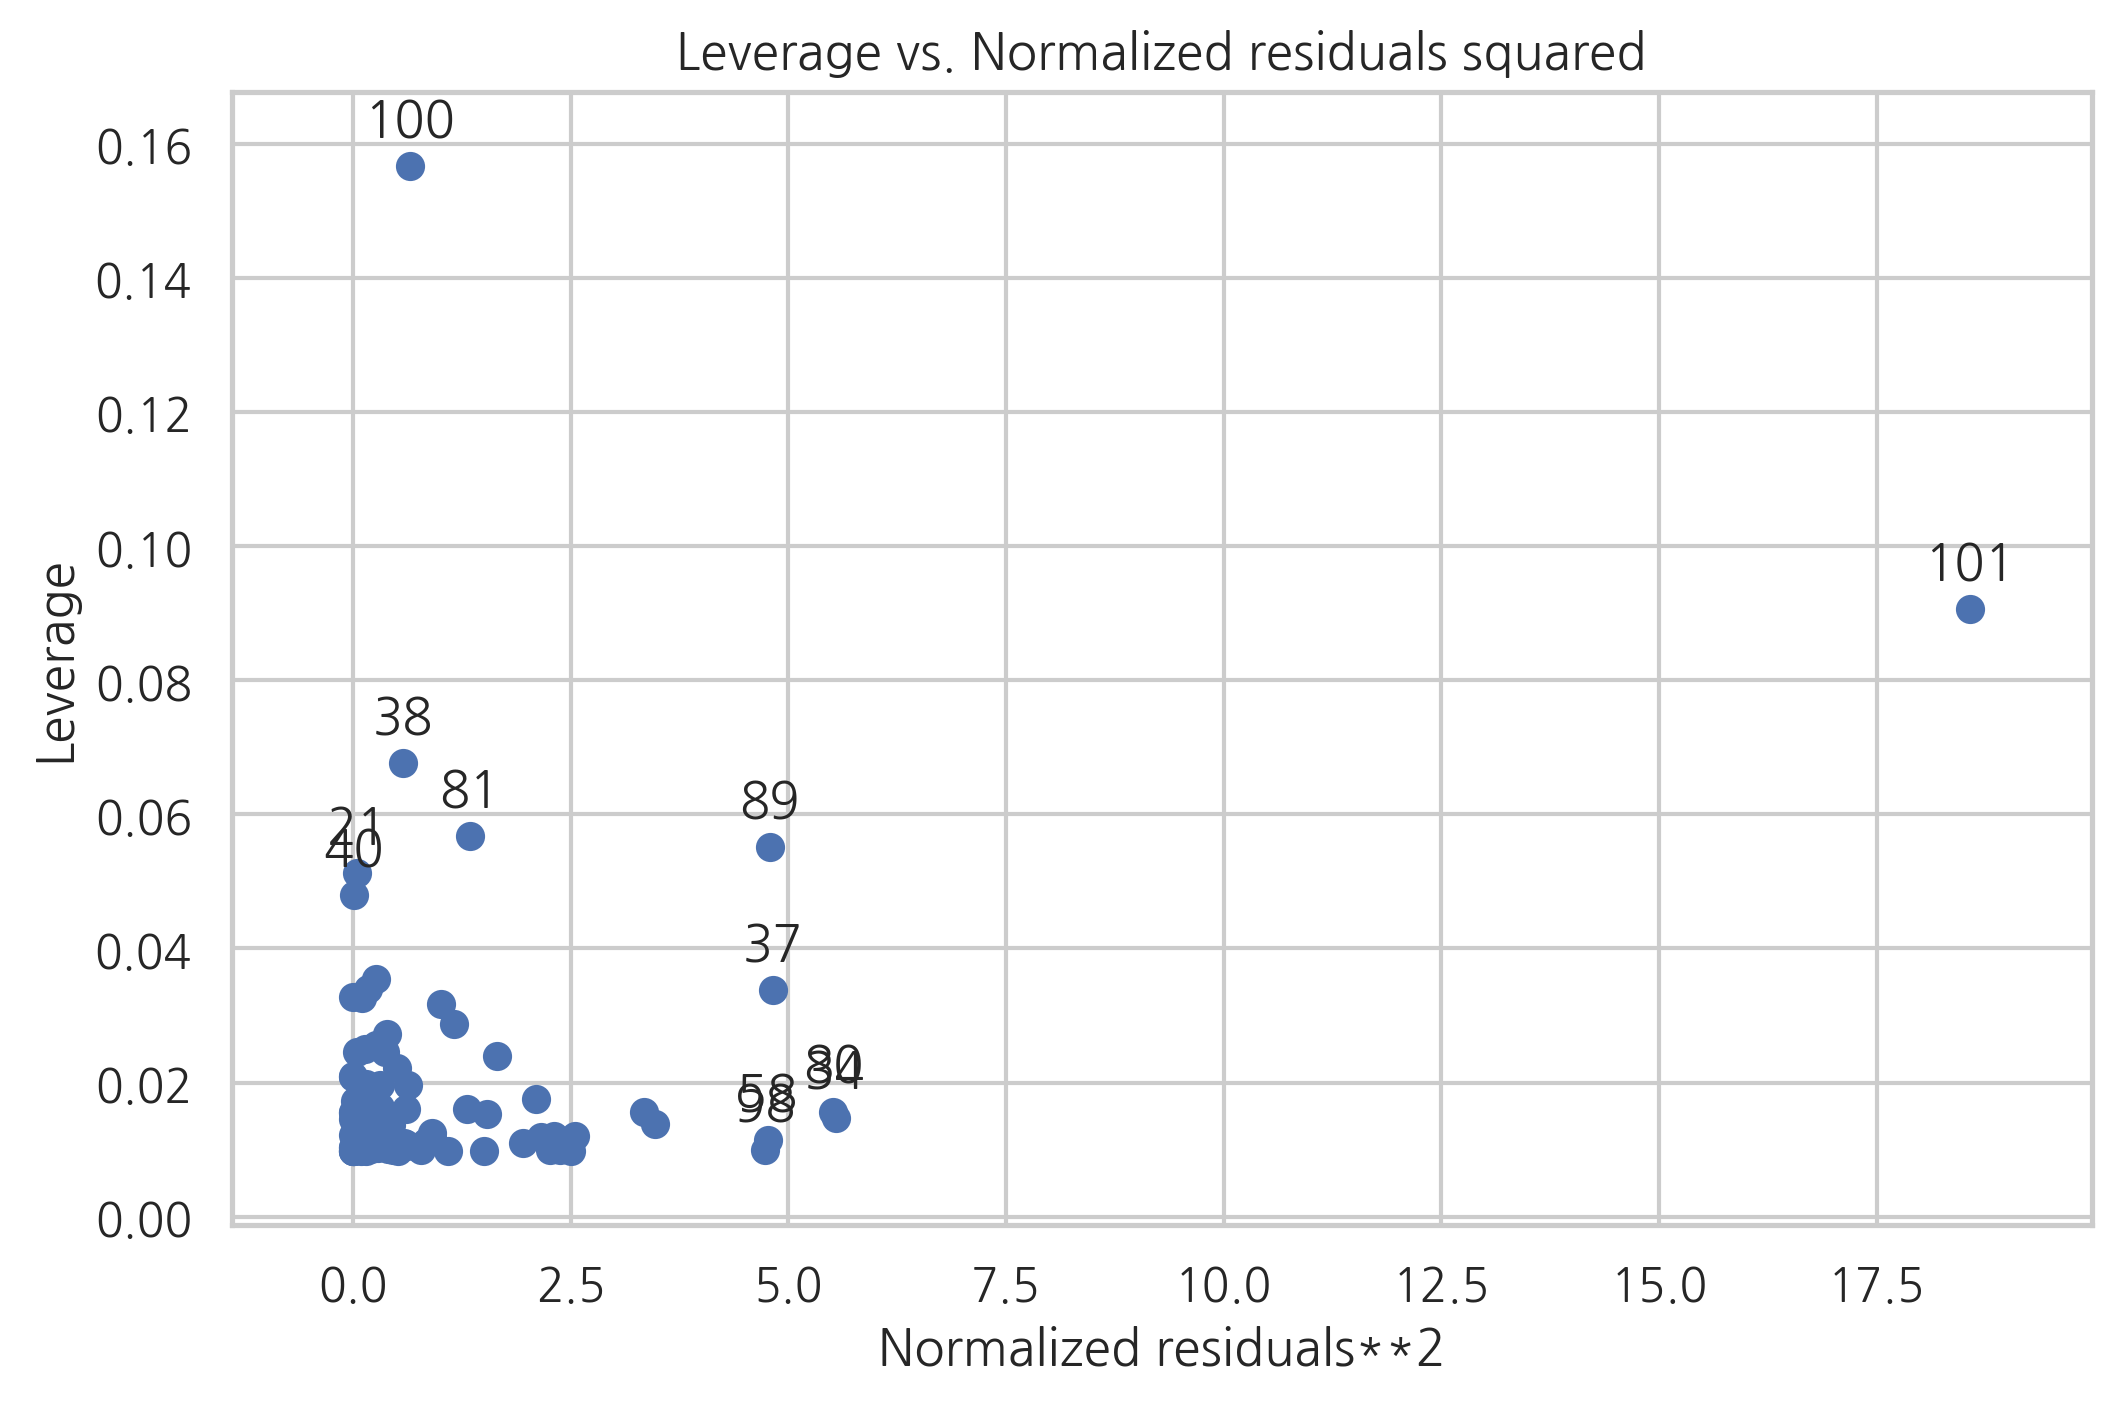

In [11]:
sm.graphics.plot_leverage_resid2(result)
plt.show()

`influence_plot` 명령을 사용하면 Cook's distance를 버블 크기로 표시한다.

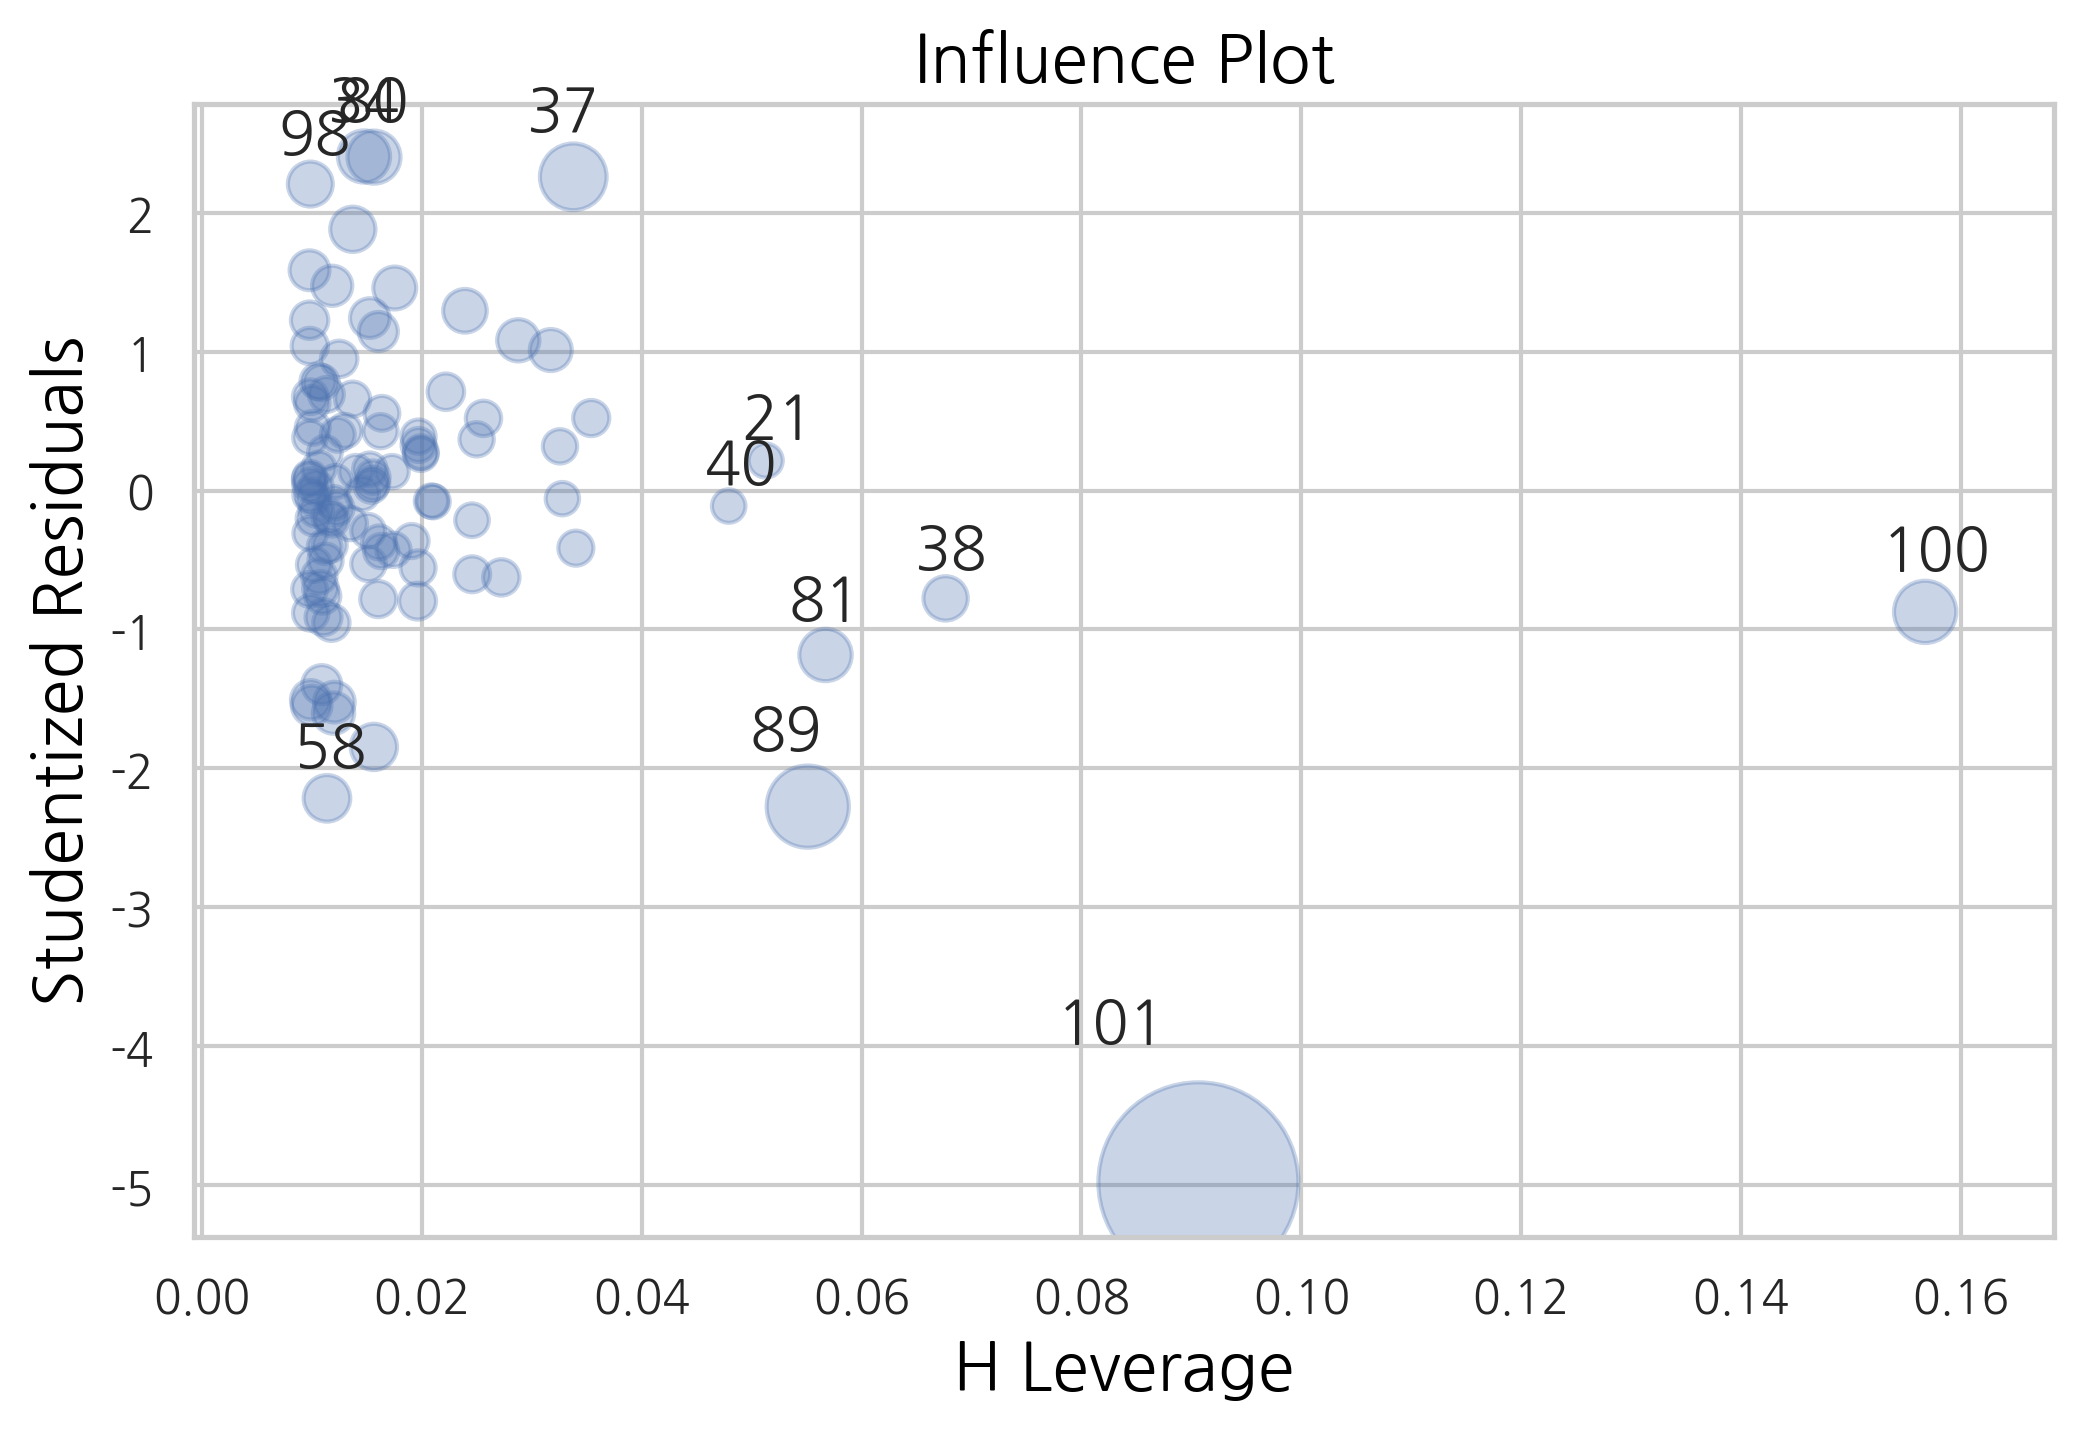

In [12]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

다음 그림은 위에서 사용한 데이터에서 Fox recommentation 기준으로 아웃라이어를 선택한 결과이다.

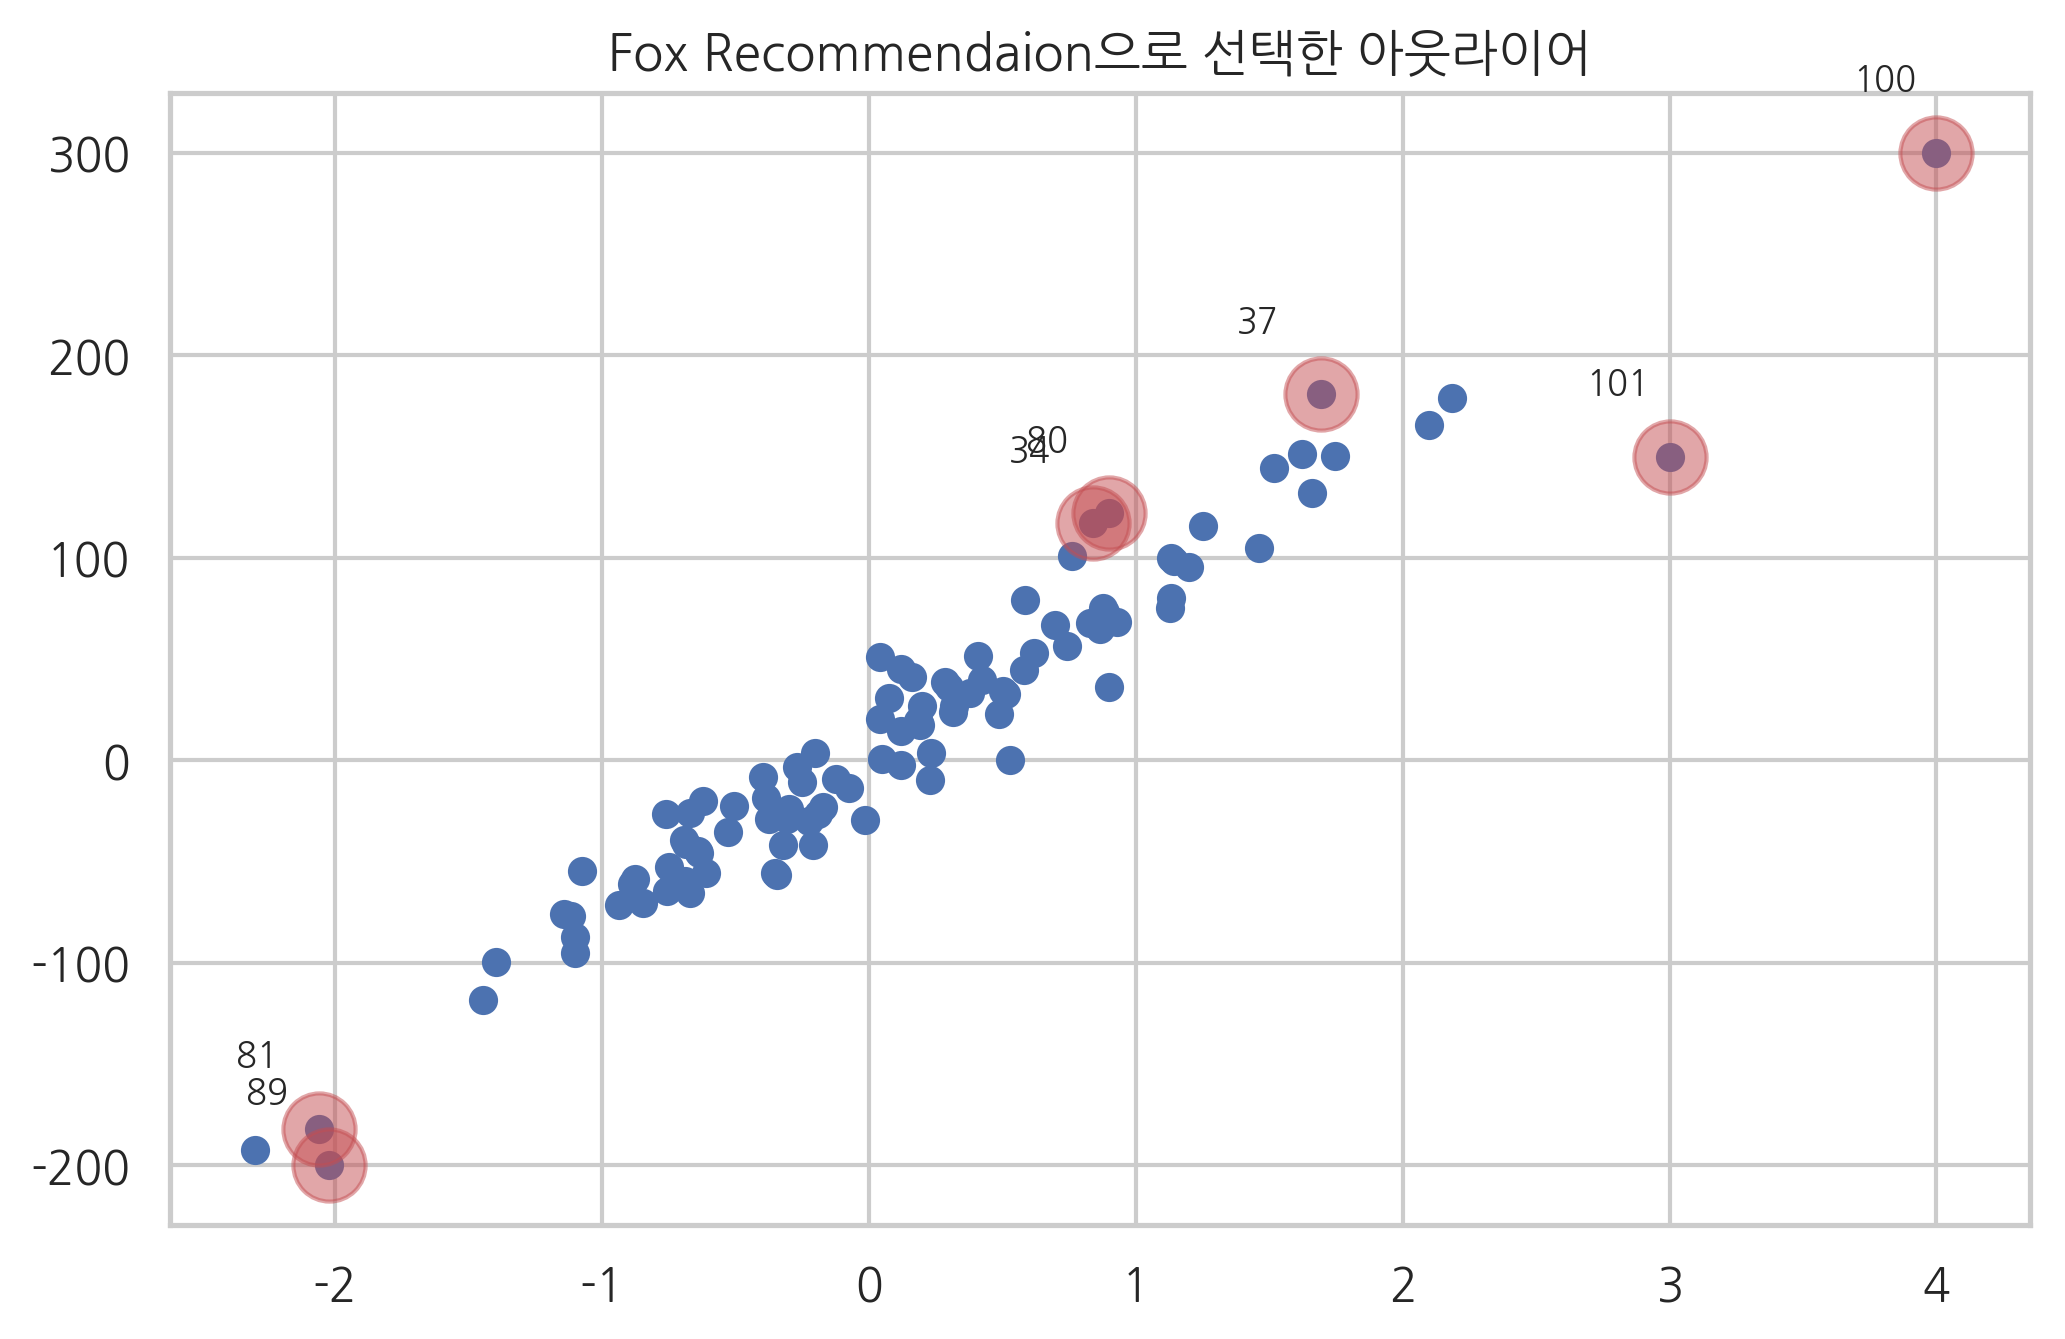

In [13]:
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(X0, y)
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(X0[idx], y[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("Fox Recommendaion으로 선택한 아웃라이어")
plt.show()

### 보스턴 집값 예측 문제

보스턴 집값 문제에 아웃라이어를 적용해 보자. MEDV가 50인 데이터는 상식적으로 생각해도 이상한 데이터이므로 아웃라이어라고 판단할 수 있다. 나머지 데이터 중에서 폭스 추천공식을 사용하여 아웃라이어를 제외한 결과는 다음과 같다.

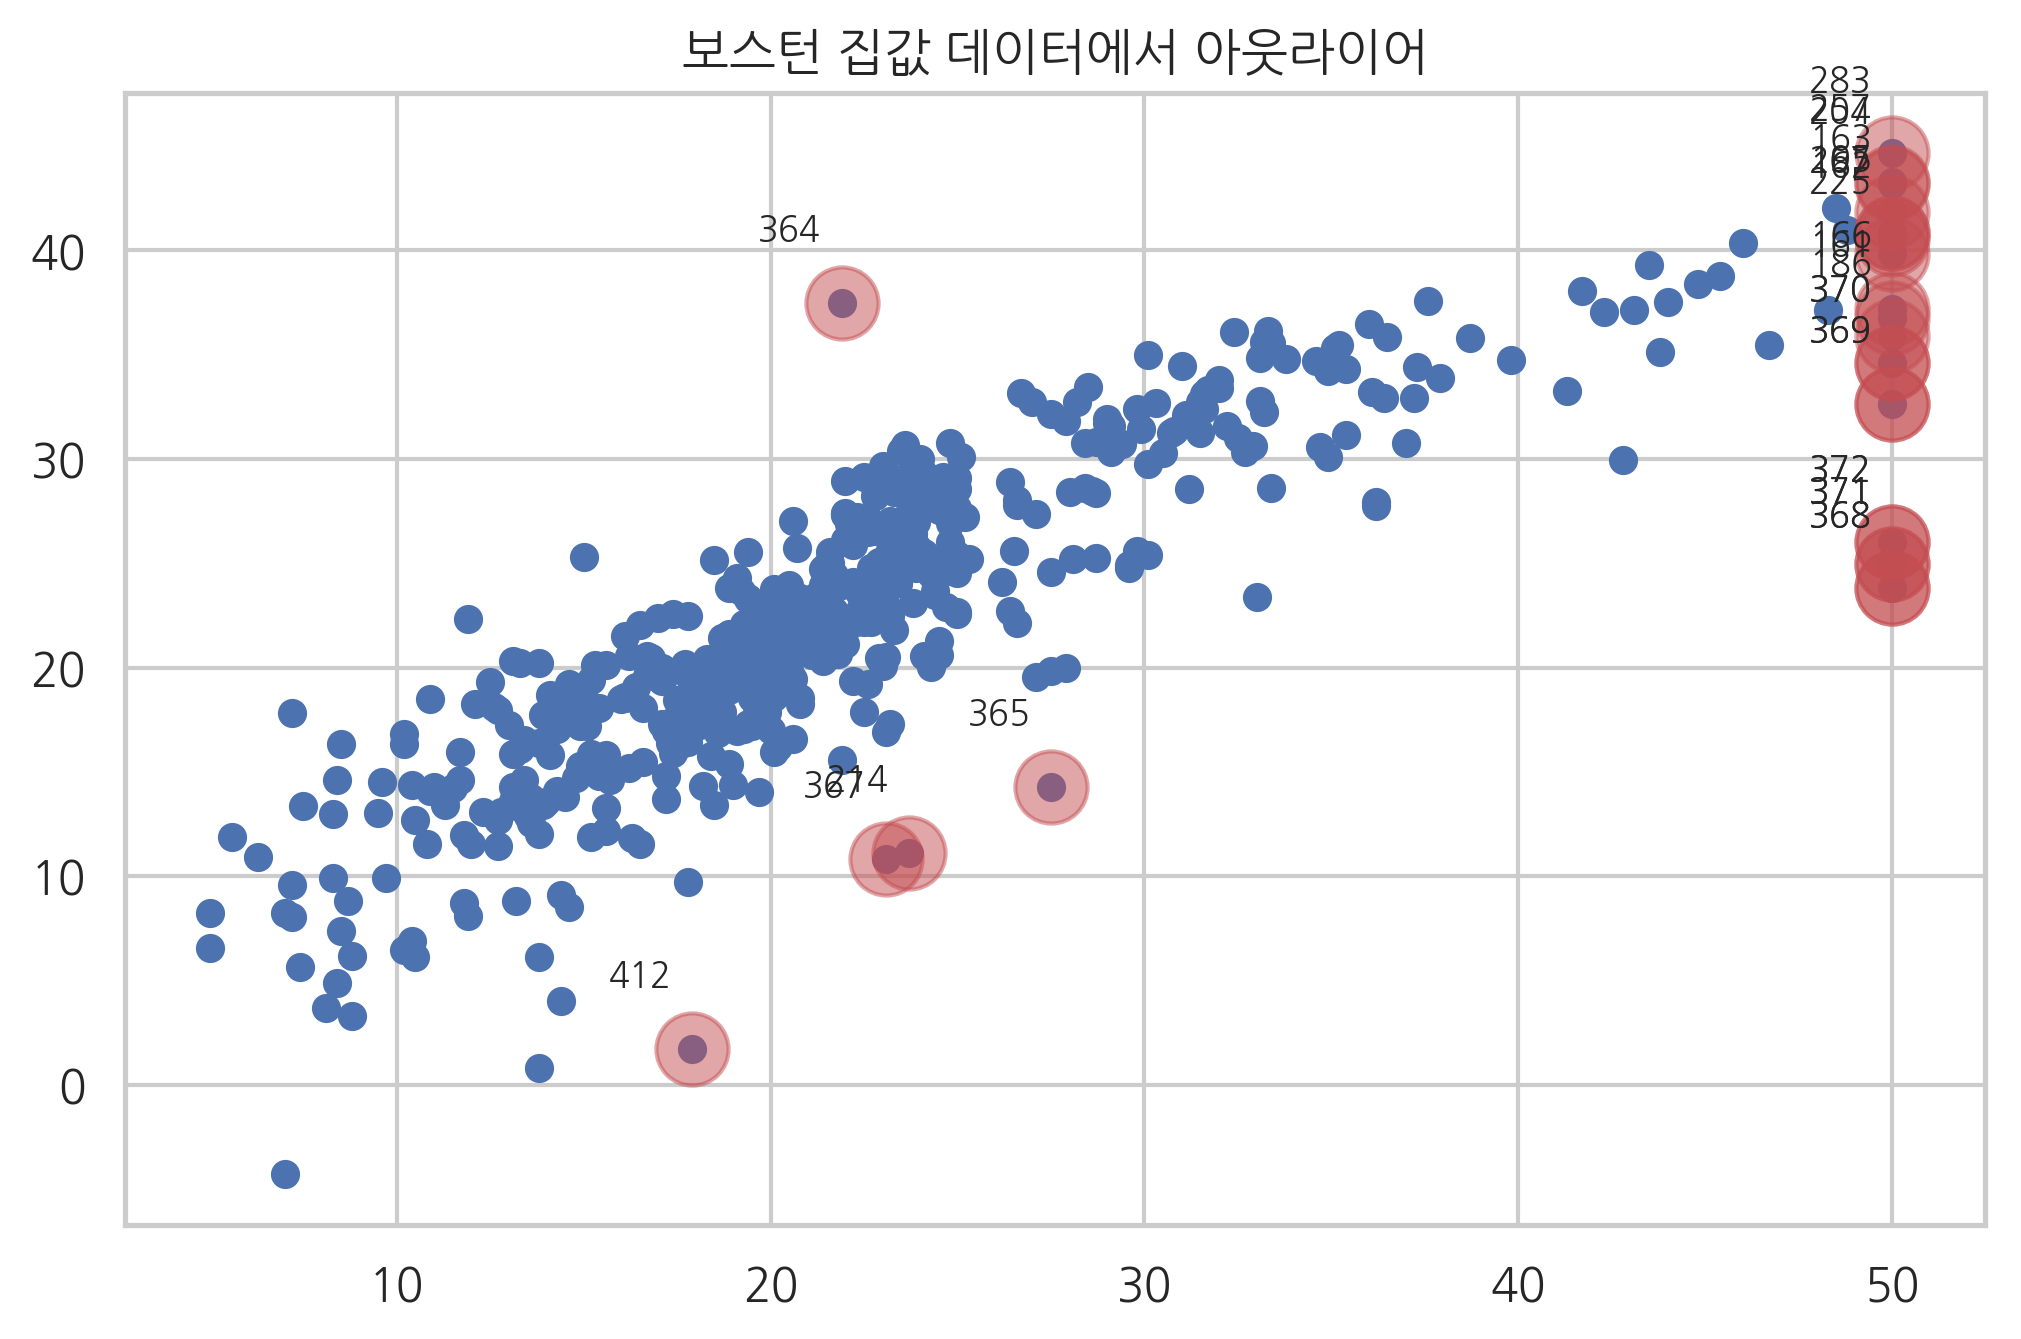

In [14]:
from sklearn.datasets import load_boston
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

model_boston = sm.OLS(dfy, dfX)
result_boston = model_boston.fit()
pred = result_boston.predict(dfX)

influence_boston = result_boston.get_influence()
cooks_d2, pvals = influence_boston.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

# MEDV = 50 제거
idx = np.hstack([idx, np.where(boston.target == 50)[0]])

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy.MEDV[idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(dfy.MEDV[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("보스턴 집값 데이터에서 아웃라이어")
plt.show()

다음은 이렇게 아웃라이어를 제외한 후에 다시 회귀분석을 한 결과이다.

In [15]:
idx2 = list(set(range(len(dfX))).difference(idx))
dfX = dfX.iloc[idx2, :].reset_index(drop=True)
dfy = dfy.iloc[idx2, :].reset_index(drop=True)
model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     156.1
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          2.41e-161
Time:                        09:35:52   Log-Likelihood:                -1285.2
No. Observations:                 485   AIC:                             2598.
Df Residuals:                     471   BIC:                             2657.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8999      4.107      4.602      0.0